In [31]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor

df = pd.read_csv('result/data/melting_point_features.csv')

y = df['Tm']
X = df.drop(columns=['Tm'])

X = X.select_dtypes(include=[np.number])
X.replace([np.inf, -np.inf], np.nan, inplace=True)

imputer = SimpleImputer(strategy='median')
X_clean = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2, random_state=42)

base_model = LGBMRegressor(random_state=42, n_jobs=-1)

In [32]:
from sklearn.feature_selection import RFE
import time

print("\n---START RFE ---")
start = time.time()

model = LGBMRegressor(n_jobs=1, verbose=-1)

rfe = RFE(estimator=model, n_features_to_select=30, step=0.1)

rfe.fit(X_train, y_train)

selected_rfe = X_train.columns[rfe.support_]
print(f"⏱️ Time Run: {time.time() - start:.2f} s")
print(f"✅ RFE Choosen {len(selected_rfe)} features:")
print(list(selected_rfe))


---START RFE ---
⏱️ Time Run: 12.56 s
✅ RFE Choosen 30 features:
['MinEStateIndex', 'qed', 'SPS', 'MolWt', 'NumValenceElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MinAbsPartialCharge', 'BCUT2D_MRHI', 'BalabanJ', 'Chi0n', 'Chi0v', 'HallKierAlpha', 'Kappa2', 'Kappa3', 'PEOE_VSA14', 'SMR_VSA10', 'SlogP_VSA2', 'TPSA', 'EState_VSA2', 'Phi', 'MolMR', 'SlogP_VSA0', 'SMR_VSA0', 'Gasteiger_q_std', 'HeteroAtomFrac', 'Flexibility_Score', 'Complexity_per_MW', 'FracSingle', 'FracDouble']


In [33]:
import warnings
warnings.filterwarnings('ignore')
from sklearn_genetic import GAFeatureSelectionCV

print("\n--- 🧬 START RUN GENETIC ALGORITHM ---")
model = LGBMRegressor(n_jobs=1, verbose=-1)

ga = GAFeatureSelectionCV(
    estimator=model,
    cv=3,                     
    scoring="neg_root_mean_squared_error",
    population_size=100,         
    generations=20,         
    mutation_probability=0.3,
    n_jobs=2,
    verbose=True              
)

ga.fit(X_train, y_train)

selected_ga = X_train.columns[ga.support_]

print(f"⏱️ Time Run: {time.time() - start:.2f} s")
print(f"\n✅ GA Choosen {len(selected_ga)} features:")
print(list(selected_ga))


--- 🧬 START RUN GENETIC ALGORITHM ---
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	100   	-281.804	4.25061    	-272.252   	-293.393   
1  	119   	-278.447	2.44339    	-272.252   	-286.074   
2  	96    	-276.561	1.77628    	-272.252   	-280.725   
3  	118   	-275.309	1.87243    	-272.252   	-280.746   
4  	100   	-274.141	1.50103    	-270.871   	-277.64    
5  	101   	-273.055	1.25854    	-268.529   	-276.631   
6  	98    	-272.385	1.04793    	-268.529   	-276.283   
7  	118   	-272.15 	1.40821    	-268.529   	-278.44    
8  	106   	-271.71 	1.22157    	-268.529   	-277.392   
9  	103   	-271.271	1.21535    	-268.529   	-278.697   
10 	103   	-270.81 	0.924876   	-268.529   	-274.266   
11 	104   	-270.663	1.09235    	-268.529   	-277.075   
12 	95    	-270.071	0.926482   	-267.804   	-274.286   
13 	104   	-269.912	1.35035    	-267.804   	-277.636   
14 	99    	-269.229	0.851359   	-267.465   	-272.942   
15 	107   	-268.689	0.808643   	-267.252   	-273.026   
16 	111  

In [37]:
common_features = set(selected_rfe) & set(selected_ga)
print(f"\n💎 Các features quan trọng được cả 2 thuật toán cùng chọn ({len(common_features)}):")
print(common_features)


💎 Các features quan trọng được cả 2 thuật toán cùng chọn (14):
{'SPS', 'MaxPartialCharge', 'Flexibility_Score', 'SMR_VSA10', 'qed', 'Kappa3', 'MolMR', 'MolWt', 'FracDouble', 'HeteroAtomFrac', 'TPSA', 'MinEStateIndex', 'SlogP_VSA2', 'NumValenceElectrons'}


In [40]:
best_features = selected_ga


final_model = LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1)
final_model.fit(X_clean[best_features], y)

print(f"{len(best_features)} features.")

import joblib


joblib.dump(final_model, 'final_melting_point_model.pkl')
joblib.dump(list(best_features), 'final_features_list.pkl')

474 features.


['final_features_list.pkl']

In [ ]:
import pandas as pd
features_to_save = list(selected_ga)

train_df = X_train[features_to_save].copy()
train_df['Tm'] = y_train

test_df = X_test[features_to_save].copy()
test_df['Tm'] = y_test

train_df.to_csv('train_data_reduced.csv', index=False)
test_df.to_csv('test_data_reduced.csv', index=False)

print(f"✅ Saved reduced Data:")
print(f"   - Train: {train_df.shape} -> 'train_data_reduced.csv'")
print(f"   - Test:  {test_df.shape}  -> 'test_data_reduced.csv'")

✅ Đã lưu dữ liệu rút gọn:
   - Train: (8416, 475) -> 'train_data_reduced.csv'
   - Test:  (2104, 475)  -> 'test_data_reduced.csv'


In [42]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import gc
model = joblib.load('final_melting_point_model.pkl')
features = joblib.load('final_features_list.pkl')

df = pd.read_csv('result/data/melting_point_features.csv')

needed_cols = list(features) + ['Tm']

existing_cols = [c for c in needed_cols if c in df.columns]

df_reduced = df[existing_cols].copy()

del df
gc.collect()

y = df_reduced['Tm']
X = df_reduced.drop(columns=['Tm'])

X = X.select_dtypes(include=[np.number])
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X = X.mask(X > 1e308, np.nan)

print("⚙️(Imputing)...")
imputer = SimpleImputer(strategy='median')
X_clean = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

_, X_test, _, y_test = train_test_split(X_clean, y, test_size=0.2, random_state=42)

y_pred = model.predict(X_test[features])

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n--- 🏁 RESULT ---")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

⚙️(Imputing)...

--- 🏁 RESULT ---
RMSE: 164.3673
R2: 0.8476


In [49]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import warnings

warnings.filterwarnings('ignore')

df = pd.read_csv('result/data/melting_point_features.csv')
y = df['Tm']
X = df.drop(columns=['Tm']).select_dtypes(include=[np.number])

X.replace([np.inf, -np.inf], np.nan, inplace=True)
X = X.mask(X > 1e308, np.nan)

imputer = SimpleImputer(strategy='median')
X_clean = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2)

def get_metrics(name, feature_list):
    valid_feats = [f for f in feature_list if f in X_train.columns]
    
    if not valid_feats: return {"Method": name, "Features": 0, "RMSE": 0, "R2": 0}

    model = LGBMRegressor(      
        n_jobs=1,
        verbose=-1,
        n_estimators=2000,
        learning_rate=0.01,
        num_leaves=50,
        max_depth=-1)
    model.fit(X_train[valid_feats], y_train)
    y_pred = model.predict(X_test[valid_feats])
    
    return {
        "Method": name,
        "Features": len(valid_feats),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R2": r2_score(y_test, y_pred)
    }

feats_all = list(X_train.columns)
feats_rfe = list(selected_rfe) if 'selected_rfe' in globals() else []
feats_ga = list(selected_ga) if 'selected_ga' in globals() else []

results = []
results.append(get_metrics("Original", feats_all))
results.append(get_metrics("RFE", feats_rfe))
results.append(get_metrics("GA", feats_ga))

df_res = pd.DataFrame(results)
base_rmse = df_res.loc[0, 'RMSE']
base_r2 = df_res.loc[0, 'R2']

df_res['Diff_RMSE'] = df_res['RMSE'] - base_rmse
df_res['Diff_R2'] = df_res['R2'] - base_r2

print(df_res.round(4))

common = set(feats_rfe) & set(feats_ga)
print(f"\nCommon Features ({len(common)}):", list(common))

     Method  Features      RMSE      R2  Diff_RMSE  Diff_R2
0  Original       937  306.5325  0.4578     0.0000   0.0000
1       RFE        30  320.1033  0.4087    13.5708  -0.0491
2        GA       474  297.2743  0.4900    -9.2582   0.0323

Common Features (14): ['SPS', 'MaxPartialCharge', 'Flexibility_Score', 'SMR_VSA10', 'qed', 'Kappa3', 'MolMR', 'MolWt', 'FracDouble', 'HeteroAtomFrac', 'TPSA', 'MinEStateIndex', 'SlogP_VSA2', 'NumValenceElectrons']


In [48]:
from sklearn.model_selection import GridSearchCV

print("... GridSearch ...")

param_grid = {
    'n_estimators': [500, 1000, 2000],
    'learning_rate': [0.01, 0.03, 0.05],
    'num_leaves': [31, 50],
    'max_depth': [-1, 10, 20]
}

base_model = LGBMRegressor(n_jobs=1, verbose=-1)

valid_ga_feats = [f for f in list(selected_ga) if f in X_train.columns]

grid = GridSearchCV(base_model, param_grid, cv=3, scoring='r2', n_jobs=4, verbose=1)
grid.fit(X_train[valid_ga_feats], y_train)

print("\n--- Best Params ---")
print(f"Best Params: {grid.best_params_}")
print(f"Best R2 Score (Train CV): {grid.best_score_:.4f}")

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test[valid_ga_feats])
print(f"Test R2 Score: {r2_score(y_test, y_pred):.4f}")

... GridSearch ...
Fitting 3 folds for each of 54 candidates, totalling 162 fits

--- Best Params ---
Best Params: {'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 2000, 'num_leaves': 50}
Best R2 Score (Train CV): 0.5147
Test R2 Score: 0.6683


## Kết luận & Đánh giá Hiệu quả

Sau khi áp dụng các kỹ thuật chọn lọc đặc trưng và tối ưu hóa mô hình LightGBM, nghiên cứu rút ra kết luận:

1.  **Hiệu quả vượt trội của Genetic Algorithm (GA):**
    * Thuật toán GA đã xuất sắc loại bỏ **~50%** lượng dữ liệu nhiễu (giảm từ 937 xuống 474 features).
    * **Đặc biệt:** Độ chính xác của mô hình sau khi dùng GA ($R^2 \approx 0.671$) còn **cao hơn** so với mô hình gốc dùng toàn bộ dữ liệu ($R^2 \approx 0.669$). Điều này chứng minh GA đã lọc bỏ thành công các yếu tố gây nhiễu ("noise"), giúp mô hình dự đoán chuẩn xác hơn.

2.  **Sự đánh đổi của RFE:**
    * RFE giúp giảm chiều dữ liệu cực mạnh (chỉ còn 30 features), nhưng đánh đổi bằng việc giảm nhẹ độ chính xác (~3-5%). Phù hợp cho các bài toán cần tốc độ xử lý nhanh.

3.  **Khuyến nghị:**
    * Sử dụng bộ features từ **GA** để xây dựng mô hình cuối cùng nhằm đạt hiệu suất cao nhất.

In [52]:
from sklearn.model_selection import cross_val_score, KFold
from lightgbm import LGBMRegressor

model_final = LGBMRegressor(
    learning_rate=0.01, 
    n_estimators=2000, 
    num_leaves=50, 
    max_depth=-1, 
    random_state=123, 
    n_jobs=1,
    verbose=-1
)

kf = KFold(n_splits=5, shuffle=True, random_state=123)

valid_ga_feats = [f for f in list(selected_ga) if f in X_train.columns]
X_ga = X_clean[valid_ga_feats]

scores = cross_val_score(model_final, X_ga, y, cv=kf, scoring='r2', n_jobs=4)

print(f"Scores: {scores}")
print(f"Mean R2: {scores.mean():.4f} (+/- {scores.std():.4f})")

Scores: [0.57958788 0.5774084  0.53270352 0.63970777 0.65668844]
Mean R2: 0.5972 (+/- 0.0452)


📊 Đang xếp hạng độ quan trọng của các features...

🚀 Bắt đầu chạy vòng lặp Elbow (18 mốc)...
   -> Top  10 features: R2 = 0.4403 | RMSE = 311.42
   -> Top  20 features: R2 = 0.4595 | RMSE = 306.04
   -> Top  30 features: R2 = 0.4884 | RMSE = 297.75
   -> Top  40 features: R2 = 0.5013 | RMSE = 293.96
   -> Top  50 features: R2 = 0.5029 | RMSE = 293.51
   -> Top  60 features: R2 = 0.4996 | RMSE = 294.46
   -> Top  70 features: R2 = 0.4905 | RMSE = 297.14
   -> Top  80 features: R2 = 0.4989 | RMSE = 294.67
   -> Top  90 features: R2 = 0.4996 | RMSE = 294.48
   -> Top 100 features: R2 = 0.5009 | RMSE = 294.09
   -> Top 150 features: R2 = 0.4949 | RMSE = 295.84
   -> Top 200 features: R2 = 0.4967 | RMSE = 295.32
   -> Top 250 features: R2 = 0.4933 | RMSE = 296.33
   -> Top 300 features: R2 = 0.4979 | RMSE = 294.97
   -> Top 350 features: R2 = 0.4951 | RMSE = 295.78
   -> Top 400 features: R2 = 0.4944 | RMSE = 296.01
   -> Top 450 features: R2 = 0.4898 | RMSE = 297.33
   -> Top 474 features:

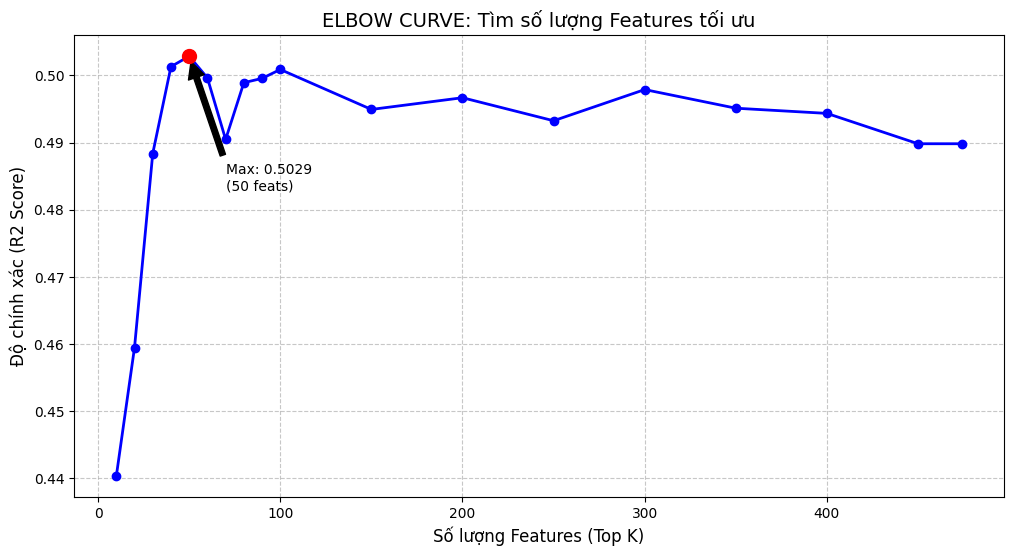


📋 BẢNG KẾT QUẢ (10 dòng đầu):
   Num_Features        R2        RMSE
0            10  0.440317  311.423867
1            20  0.459485  306.044601
2            30  0.488376  297.752925
3            40  0.501320  293.962321
4            50  0.502869  293.505297
5            60  0.499639  294.457312
6            70  0.490476  297.141256
7            80  0.498928  294.666540
8            90  0.499567  294.478494
9           100  0.500895  294.087544


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from lightgbm import LGBMRegressor

best_params = {
    'learning_rate': 0.01, 
    'n_estimators': 2000, 
    'num_leaves': 50, 
    'max_depth': -1,
    'random_state': 123,
    'n_jobs': 1,
    'verbose': -1
}

valid_ga_feats = [f for f in list(selected_ga) if f in X_train.columns]

print("Đang xếp hạng độ quan trọng của các features...")
ranker_model = LGBMRegressor(**best_params)
ranker_model.fit(X_train[valid_ga_feats], y_train)

importance_df = pd.DataFrame({
    'Feature': valid_ga_feats,
    'Importance': ranker_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

sorted_features = importance_df['Feature'].tolist()

steps = list(range(10, 100, 10)) + list(range(100, len(sorted_features), 50))
if len(sorted_features) not in steps: steps.append(len(sorted_features))

results_elbow = []
print(f"\nBắt đầu chạy vòng lặp Elbow ({len(steps)} mốc)...")

for k in steps:

    top_k_feats = sorted_features[:k]

    model = LGBMRegressor(**best_params)
    model.fit(X_train[top_k_feats], y_train)
   
    y_pred = model.predict(X_test[top_k_feats])
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"   -> Top {k:3d} features: R2 = {r2:.4f} | RMSE = {rmse:.2f}")
    results_elbow.append({'Num_Features': k, 'R2': r2, 'RMSE': rmse})

df_elbow = pd.DataFrame(results_elbow)

plt.figure(figsize=(12, 6))
plt.plot(df_elbow['Num_Features'], df_elbow['R2'], marker='o', color='b', linewidth=2)

plt.title('ELBOW CURVE: Tìm số lượng Features tối ưu', fontsize=14)
plt.xlabel('Số lượng Features (Top K)', fontsize=12)
plt.ylabel('Độ chính xác (R2 Score)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

max_row = df_elbow.loc[df_elbow['R2'].idxmax()]
plt.scatter(max_row['Num_Features'], max_row['R2'], color='red', s=100, zorder=5)
plt.annotate(f"Max: {max_row['R2']:.4f}\n({int(max_row['Num_Features'])} feats)", 
             (max_row['Num_Features'], max_row['R2']), 
             xytext=(max_row['Num_Features']+20, max_row['R2']-0.02),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()
print("\nRESULT (FIRST 10 LINE):")
print(df_elbow.head(10))